# Preprocesamiento de Dataset

- Se detalla desde la obtención de la base de datos hasta la división de la misma en train y test



## Instalar e importar bibliotecas


In [1]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 25.9 MB/s eta 0:00:00


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("danielshanbalico/dog-emotion")

print("Path to dataset files:", path)

100%|██████████| 155M/155M [00:01<00:00, 94.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/danielshanbalico/dog-emotion/versions/1


In [4]:


# Librerías del sistema y utilidades generales
import os
import time
import random
from collections import Counter

# Librerías Numéricas y DataFrame
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
%matplotlib inline

# OpenCV (para procesamiento de imágenes)
import cv2

# PyTorch y Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

# PyTorch Lightning (para entrenamientos estructurados)
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar
from pytorch_lightning.loggers import CSVLogger

# Torchvision (para procesamiento de imágenes)
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets

# DataLoaders y manejo de datasets
from torch.utils.data import DataLoader, random_split

# YOLO (detección de objetos)
from ultralytics import YOLO  # Asegúrate de tener ultralytics instalado

# Hash para valores unicos
import hashlib

# Divion Train Test
from sklearn.model_selection import train_test_split


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Ruta ajustada al directorio de las imágenes
dataset_path = os.path.join(path, "Dog Emotion")
print(dataset_path)

/root/.cache/kagglehub/datasets/danielshanbalico/dog-emotion/versions/1/Dog Emotion


In [6]:

# Contador de elementos en cada subcarpeta
subfolder_counts = {}

# Verificar si la ruta existe
if os.path.exists(dataset_path):
    for subdir in os.listdir(dataset_path):
        subdir_path = os.path.join(dataset_path, subdir)
        if os.path.isdir(subdir_path):  # Verificar que sea un directorio
            num_files = len(os.listdir(subdir_path))
            subfolder_counts[subdir] = num_files

# Convertir a DataFrame y mostrar
df_subfolder_counts = pd.DataFrame(list(subfolder_counts.items()), columns=["Subcarpeta", "Número de elementos"])

# Mostrar el DataFrame
df_subfolder_counts


,Subcarpeta,Número de elementos
0,relaxed,1000
1,sad,1000
2,happy,1000
3,angry,1000


In [7]:
# Transformaciones para convertir imágenes en tensores
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # Convertir a tensor
])

# Cargar el dataset sin dividir en train/test/valid
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Almacenar los datos en un DataFrame
image_data = []

# Leer cada imagen y guardarla en un DataFrame junto con su nombre de archivo
for idx, (img_tensor, label_idx) in enumerate(dataset):
    class_name = dataset.classes[label_idx]  # Obtener nombre de la clase
    file_path, _ = dataset.samples[idx]  # Obtener ruta completa del archivo
    file_name = os.path.basename(file_path)  # Extraer solo el nombre del archivo con extensión

    # Crear hash de la imagen para detectar duplicados
    img_hash = hashlib.md5(img_tensor.numpy().tobytes()).hexdigest()

    # Guardar en lista
    image_data.append({
        "file_name": file_name,  # Nombre del archivo con extensión
        "tensor": img_tensor,    # Guardamos el tensor de la imagen
        "label": class_name,     # Etiqueta de la imagen
        "hash": img_hash         # Hash único de la imagen
    })

# Convertir lista en DataFrame de pandas
df_images = pd.DataFrame(image_data)

# Contar cantidad de imágenes por etiqueta (label)
label_counts = df_images["label"].value_counts()
print("Número de imágenes por etiqueta:\n", label_counts)



Número de imágenes por etiqueta:
 label
angry      1000
happy      1000
relaxed    1000
sad        1000
Name: count, dtype: int64


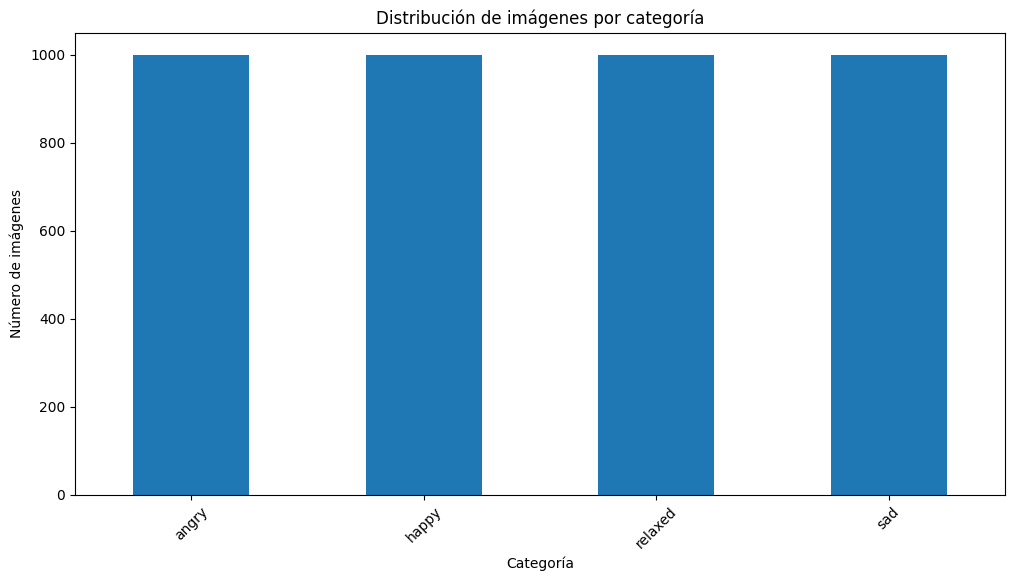

In [8]:
# Crear gráfico de barras para mostrar el número de imágenes por categoría
plt.figure(figsize=(12, 6))
label_counts.plot(kind="bar")

# Personalización del gráfico
plt.xlabel("Categoría")
plt.ylabel("Número de imágenes")
plt.title("Distribución de imágenes por categoría")
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad

# Mostrar gráfico
plt.show()

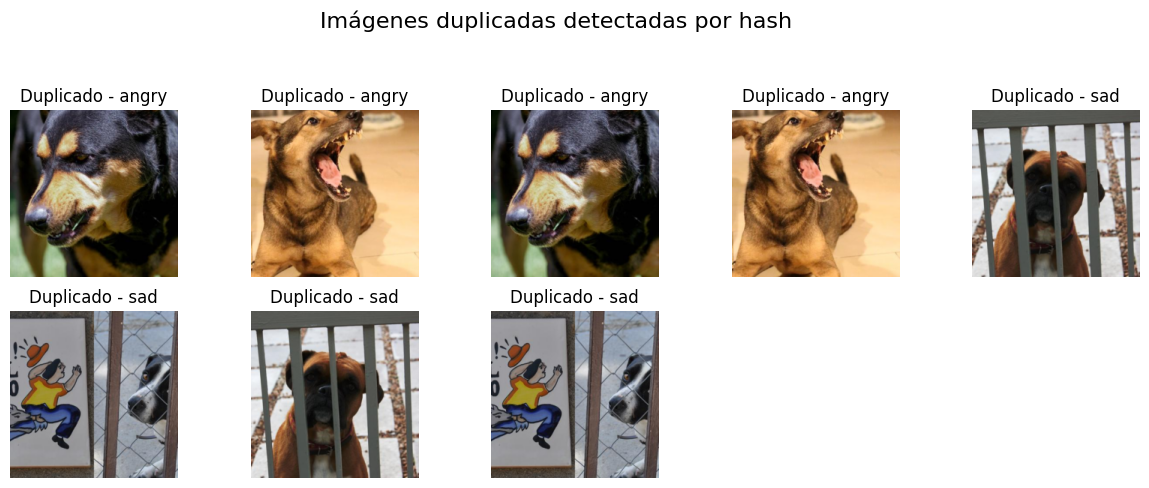

In [9]:

# Filtrar imágenes duplicadas según el hash
duplicate_hashes = df_images[df_images.duplicated(subset=["hash"], keep=False)]

# Mostrar las imágenes duplicadas
if not duplicate_hashes.empty:
    plt.figure(figsize=(15, 10))  # Ajustar tamaño de la figura
    for i, row in enumerate(duplicate_hashes.itertuples()):
        if i == 20:  # Mostrar máximo 20 imágenes duplicadas
            break

        plt.subplot(4, 5, i + 1)  # Crear una cuadrícula de 4 filas x 5 columnas
        img_np = row.tensor.permute(1, 2, 0).numpy()
        img_np = (img_np * 255).astype(np.uint8)

        plt.imshow(img_np)
        plt.title(f"Duplicado - {row.label}")
        plt.axis("off")

    plt.suptitle("Imágenes duplicadas detectadas por hash", fontsize=16)
    plt.show()
else:
    print("No se encontraron imágenes duplicadas según el hash.")


In [10]:
# Eliminar imágenes duplicadas según el hash (conservar la primera aparición)
df_images = df_images.drop_duplicates(subset=["hash"], keep="first")

In [11]:
# Contar cantidad de imágenes por etiqueta (label)
label_counts = df_images["label"].value_counts()
print("Número de imágenes por etiqueta:\n", label_counts)

Número de imágenes por etiqueta:
 label
happy      1000
relaxed    1000
angry       998
sad         998
Name: count, dtype: int64


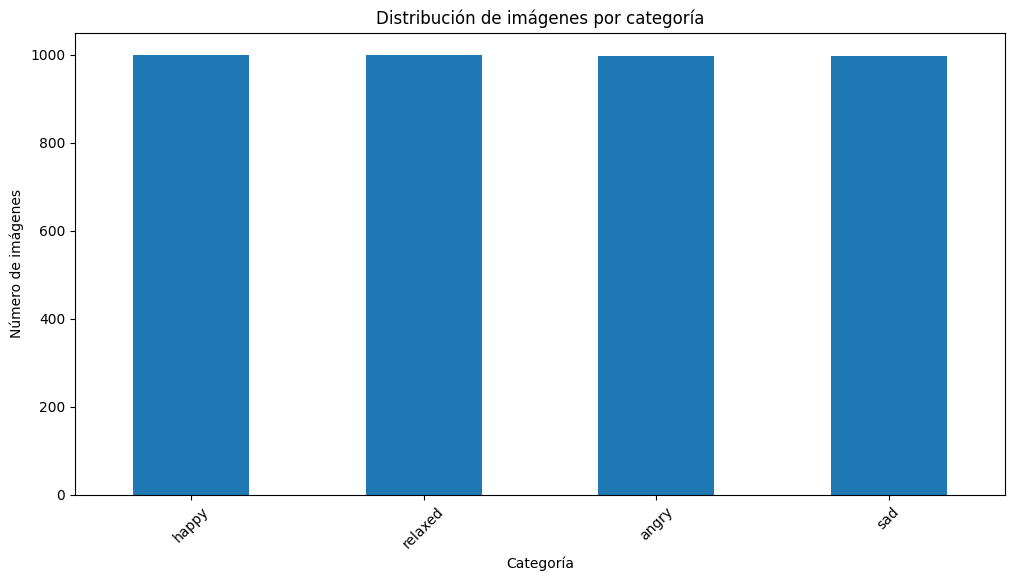

In [12]:
# Crear gráfico de barras para mostrar el número de imágenes por categoría
plt.figure(figsize=(12, 6))
label_counts.plot(kind="bar")

# Personalización del gráfico
plt.xlabel("Categoría")
plt.ylabel("Número de imágenes")
plt.title("Distribución de imágenes por categoría")
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad

# Mostrar gráfico
plt.show()

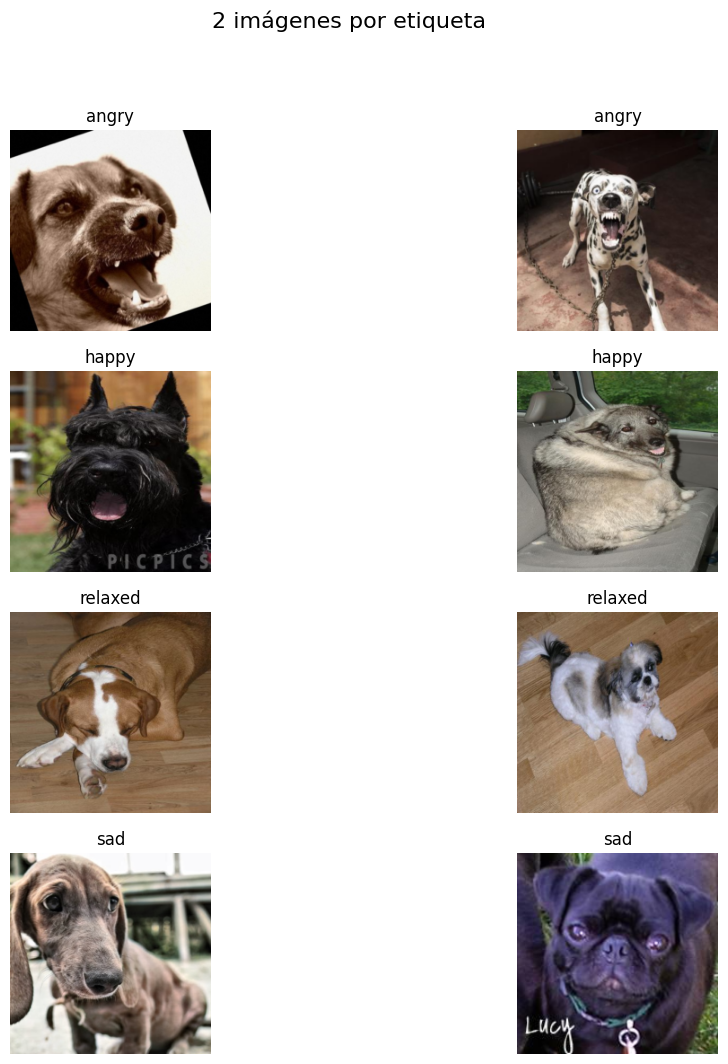

In [13]:
import matplotlib.pyplot as plt

# Obtener todas las etiquetas únicas en el DataFrame
unique_labels = df_images["label"].unique()

# Diccionario para almacenar imágenes seleccionadas por etiqueta
selected_images = {label: [] for label in unique_labels}

# Iterar sobre las imágenes y seleccionar 2 por cada etiqueta
for row in df_images.itertuples():
    if len(selected_images[row.label]) < 2:  # Seleccionar solo 2 imágenes por etiqueta
        selected_images[row.label].append(row.tensor)

    if all(len(imgs) == 2 for imgs in selected_images.values()):  # Detener cuando tengamos 2 por cada clase
        break

# Mostrar las imágenes seleccionadas
plt.figure(figsize=(12, len(selected_images) * 3))
for i, (label, images) in enumerate(selected_images.items()):
    for j, img_tensor in enumerate(images):
        plt.subplot(len(selected_images), 2, i * 2 + j + 1)
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = (img_np * 255).astype(np.uint8)

        plt.imshow(img_np)
        plt.title(f"{label}")
        plt.axis("off")

plt.suptitle("2 imágenes por etiqueta", fontsize=16)
plt.show()


# Identificar Perro Yolo

In [14]:
# Cargar modelo YOLOv8 preentrenado
yolo_model = YOLO("yolov8n.pt")  # Modelo ligero para detección

100%|██████████| 6.25M/6.25M [00:00<00:00, 89.0MB/s]


In [15]:

# Función para detectar si hay un perro en la imagen (sin guardar la probabilidad)
def detect_dog(image_tensor):
    """Detecta si una imagen contiene un perro según YOLO."""
    image_np = image_tensor.permute(1, 2, 0).numpy()  # Convertir tensor a numpy
    image_np = (image_np * 255).astype(np.uint8)  # Escalar a 0-255
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  # Convertir a formato BGR para YOLO

    results = yolo_model(image_bgr)  # Pasar imagen por YOLO
    detected_dog = any(yolo_model.names[int(box.cls)] == "dog" for box in results[0].boxes)

    return detected_dog  # Solo devuelve si hay o no un perro

# Aplicar YOLO a cada imagen y agregar los resultados al DataFrame
df_images["contiene_perro"] = df_images["tensor"].apply(detect_dog)




Se han truncado las últimas 5000 líneas del flujo de salida.
0: 640x640 1 dog, 12.4ms
Speed: 3.9ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 1 cell phone, 10.8ms
Speed: 3.6ms preprocess, 10.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 11.0ms
Speed: 3.7ms preprocess, 11.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 13.1ms
Speed: 5.7ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cat, 1 bowl, 1 bed, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 10.6ms
Speed: 4.9ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.7ms
Speed: 3.3ms preprocess, 10.7ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 19.4ms
Speed: 3.3ms preproce

In [16]:
df_images["contiene_perro"].value_counts()

,count
contiene_perro,
True,2921
False,1075


In [17]:

# Fijar semilla para reproducibilidad
np.random.seed(999)

# Realizar división estratificada por etiqueta
train_idx, test_idx = train_test_split(
    df_images.index, test_size=0.1, stratify=df_images["label"], random_state=999
)

# Asignar valores a la nueva columna "subset"
df_images.loc[train_idx, "subset"] = "train"
df_images.loc[test_idx, "subset"] = "test"

# Mostrar distribución de Train/Test por etiqueta
subset_counts = df_images.groupby(["label", "subset"]).size().unstack()
print("Distribución estratificada del dataset:\n", subset_counts)



Distribución estratificada del dataset:
 subset   test  train
label               
angry     100    898
happy     100    900
relaxed   100    900
sad       100    898


In [18]:
df_images["contiene_perro"].value_counts()

,count
contiene_perro,
True,2921
False,1075


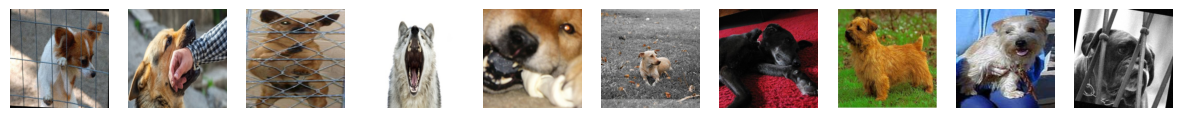

In [19]:


# Filtrar solo las imágenes que no contienen perro y seleccionar 10 aleatorias
df_sin_perros = df_images[df_images["contiene_perro"] == False].sample(n=10, random_state=999)

# Crear la figura y los ejes para la cantidad correcta de imágenes
fig, axes = plt.subplots(1, len(df_sin_perros), figsize=(15, 5))

# Manejar el caso de que haya solo una imagen
if len(df_sin_perros) == 1:
    axes = [axes]

for ax, (_, row) in zip(axes, df_sin_perros.iterrows()):
    imagen = row["tensor"].squeeze().numpy()  # Convertir tensor a numpy array

    # Si la imagen tiene 3 canales (CHW), cambiar a formato HWC
    if imagen.ndim == 3 and imagen.shape[0] in [1, 3]:
        imagen = imagen.transpose(1, 2, 0)

    ax.imshow(imagen, cmap="gray" if imagen.ndim == 2 else None)
    ax.axis("off")

plt.show()



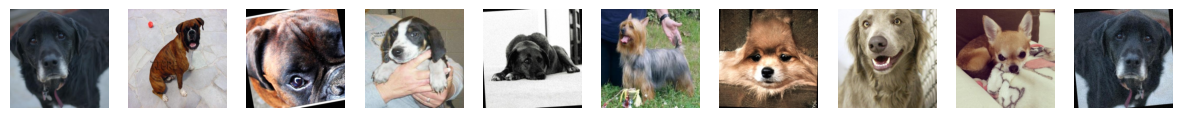

In [20]:
# Filtrar solo las imágenes que no contienen perro y seleccionar 10 aleatorias
df_con_perros = df_images[df_images["contiene_perro"] == True].sample(n=10, random_state=999)

# Crear la figura y los ejes para la cantidad correcta de imágenes
fig, axes = plt.subplots(1, len(df_con_perros), figsize=(15, 5))

# Manejar el caso de que haya solo una imagen
if len(df_con_perros) == 1:
    axes = [axes]

for ax, (_, row) in zip(axes, df_con_perros.iterrows()):
    imagen = row["tensor"].squeeze().numpy()  # Convertir tensor a numpy array

    # Si la imagen tiene 3 canales (CHW), cambiar a formato HWC
    if imagen.ndim == 3 and imagen.shape[0] in [1, 3]:
        imagen = imagen.transpose(1, 2, 0)

    ax.imshow(imagen, cmap="gray" if imagen.ndim == 2 else None)
    ax.axis("off")

plt.show()


In [21]:
# Contar cantidad de imágenes por etiqueta (label)
label_counts = df_images["label"].value_counts()
print("Número de imágenes por etiqueta:\n", label_counts)


Número de imágenes por etiqueta:
 label
happy      1000
relaxed    1000
angry       998
sad         998
Name: count, dtype: int64


In [22]:
df_images.head(2)

,file_name,tensor,label,hash,contiene_perro,subset
0,09dUVMcjCDfOtbeYDQg5Fvu3GPHWJg811.jpg,"[[[tensor(0.0039), tensor(0.0118), tensor(0.),...",angry,4da78b5b3b24c75e9b2fb40c938aab57,True,train
1,0AvKtuzA7LfxnKaO0bey9mQMLnxXad73.jpg,"[[[tensor(0.4118), tensor(0.4118), tensor(0.41...",angry,14822cd502ec2c6a8c320f046a22b7e4,True,train


In [23]:
df_images.dtypes

,0
file_name,object
tensor,object
label,object
hash,object
contiene_perro,bool
subset,object


# Identificar Razas

In [24]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Cargar el modelo ResNet-50 preentrenado
model = models.resnet50(pretrained=True)
model.eval()  # Establecer el modelo en modo de evaluación


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
# Definir las transformaciones: redimensionar, recortar al centro, convertir a tensor y normalizar
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [27]:
import urllib.request
import json

url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
urllib.request.urlretrieve(url, "imagenet_class_index.json")

with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)

idx_to_label = {int(key): value[1] for key, value in class_idx.items()}


In [28]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os

# Modelo preentrenado
model = models.resnet50(pretrained=True)
model.eval()

# Transformaciones necesarias
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
def predict_breed_from_tensor(img_tensor):
    # Asegurarse que sea un tensor de PyTorch
    img_pil = transforms.ToPILImage()(img_tensor)
    img_preprocessed = preprocess(img_pil).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_preprocessed)
        _, predicted_idx = outputs.max(1)
        predicted_label = idx_to_label[predicted_idx.item()]

    return predicted_label


In [ ]:
# Aplica la función y crea la columna "raza_perro"
df_images["raza_perro"] = df_images["tensor"].apply(predict_breed_from_tensor)


In [ ]:
df_images["raza_perro"].value_counts()

In [ ]:
import matplotlib.pyplot as plt

# Agrupar por raza_perro, máximo 5 imágenes por raza
razas_unicas = df_images['raza_perro'].unique()

for raza in razas_unicas:
    df_raza = df_images[(df_images['contiene_perro'] == True) & (df_images['raza_perro'] == raza)]

    # Limitar a máximo 5 imágenes por raza
    df_raza = df_raza.sample(min(5, len(df_raza)), random_state=999)

    # Crear la figura con el número adecuado de imágenes
    fig, axes = plt.subplots(1, len(df_raza), figsize=(15, 5))

    if len(df_raza) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, df_raza.iterrows()):
        imagen = row["tensor"].numpy()  # Convertir tensor a numpy array

        # Ajustar canales CHW a formato HWC
        if imagen.ndim == 3 and imagen.shape[0] in [1, 3]:
            imagen = imagen.transpose(1, 2, 0)

        ax.imshow(imagen, cmap="gray" if imagen.ndim == 2 else None)
        ax.axis("off")
        ax.set_title(raza)

    plt.suptitle(f"Raza identificada: {raza}", fontsize=16)
    plt.show()


In [ ]:
# Guardar DataFrame en un archivo CSV (sin la columna de tensores)
df_images.to_csv("imagenes_procesadas_para_modelamiento.csv", index=False)